# Inferring biological phases by clustering snapshots

This notebook is based on the analysis performed in 

"Inferring cell cycle phases from a partially temporal network of protein interactions"  
by Lucas et al. in Cell Reports Methods (2023)  
https://doi.org/10.1016/j.crmeth.2023.100397

Here, we infer biological phases of the cell cycle by clustering the snapshot of the temporal network.  
First, we compute a fixed number of clusters. Then, we compute a range of numbers of clusters, to explore a range of timescales. 

In [14]:
import string
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

import phasik as pk # pip install phasik (requires pandas < 2.0)
# https://gitlab.com/habermann_lab/phasik

sb.set_context("notebook")

## 1. Build temporal network

In [15]:
# load static PPI network
static_net_filepath = "phasik_data/static_PPI_network_KEGG.adjlist"
static_network = nx.read_adjlist(static_net_filepath)  # networkx Graph object

pk.graph_size_info(static_network)

# load edge time series
edge_activity_filepath = f"phasik_data/edge_time_series_normed.csv"
# edge_activity_filepath = "data/chen/edge_time_series.csv"
norm = True

# use this for non-normalised time series
# edge_activity_filepath = "data/chen/edge_time_series.csv"
# norm = False

edge_series = pd.read_csv(edge_activity_filepath).transpose()
times = list(edge_series.columns)

# build temporal network

# this function buils a TemporalNetwork, by integrating the edge time series to the static network,
# and setting a constant default weight value for edges for which we have no temporal information
temporal_network = pk.TemporalNetwork.from_static_network_and_edge_timeseries(
    static_network,
    edge_series,
    static_edge_default_weight=1,
    quiet=True,  # if True, prints less information
)


A PartiallyTemporalNetwork is created instead.


/Users/maxime/.pyenv/versions/python_39/lib/python3.9/site-packages/phasik/classes/TemporalNetwork.py:171: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._tedges = self._tedges.append(tedges_to_add)


In [18]:
print(f"Temporal network shape (N, T): {temporal_network.shape()}")
print(pk.graph_size_info(static_network))
print(f"Number of temporal edges: {temporal_network.number_of_temporal_edges()}")

Temporal network shape (N, T): (83, 102)
83 nodes and 159 edges
Number of temporal edges: 34


## 2. Infer biological phases with hierarchical clustering

In [19]:
# clustering parameters
distance_metric = "euclidean"  # used to compute distance between snapshots
clustering_method = "ward"  # used to compute the distance between clusters
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

# plotting parameters

events_times = [5, 33, 36, 70, 84, 100]
events_labels = ["START", "bud", "ori", "E3", "spn", "mass"]
events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]
phases = [(0, 35, "G1"), (35, 70, "S"), (70, 78, "G2"), (78, 100, "M")]

time_ticks = range(101, 10)
# variables_to_plot = []

### 2.1 Single number of clusters

In [20]:
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)

cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_46378/2812442001.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(range(0, 101, 20))


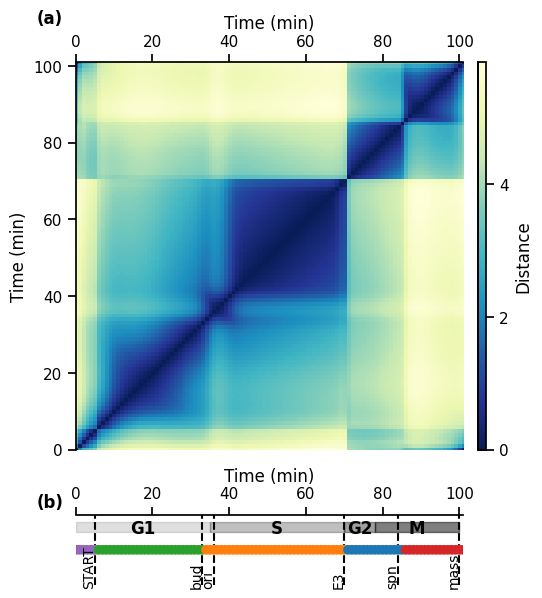

In [21]:
# plot clusters

gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gs_kw, sharex=True, figsize=(5, 7))

# distance matrix
im = ax1.imshow(
    distance_matrix.distance_matrix,
    aspect="equal",
    origin="lower",
    cmap="YlGnBu_r",
)
sb.despine(ax=ax1, top=False, bottom=True)

ax1.set_ylim(0, 101)
ax1.set_ylabel("Time (min)")
ax1.set_xlabel("Time (min)")
ax1.xaxis.set_label_position("top")
ax1.xaxis.set_ticks_position("top")

# clusters
cluster_set.plot(ax=ax2, colors=[4, 5, 3, 2, 1], y_height=0)
# cluster_set.plot(ax=ax2, colours=None)

sb.despine(ax=ax2, left=True, bottom=True, top=False)
# only way to get rid of spine offset in scatter plot apparently
ax2.set_xlim(0, 101)
ax2.set_yticks([])
ax2.set_xlabel("Time (min)")
ax2.set_xticklabels(range(0, 101, 20))
ax2.xaxis.set_label_position("top")

pk.plot_phases(phases, ax=ax2, y_pos=0.8, ymax=0.9, ymin=0.75)
pk.plot_events(events, ax=ax2, text_y_pos=-0.06, text_x_offset=1.5)

# colorbar
cax = fig.add_axes((0, 0, 1, 0.1))
pos1 = ax1.get_position()  # get the original position
pos2 = [
    pos1.x0 + pos1.width + 0.03,
    pos1.y0,
    pos1.width * 0.02,
    pos1.height,
]  # vertical
cax.set_position(pos2)  # set a new position

cb = fig.colorbar(im, cax=cax)
cb.set_ticks([0, 2, 4])
cb.set_label("Distance")
sb.despine(ax=cax)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.1,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )


plt.show()

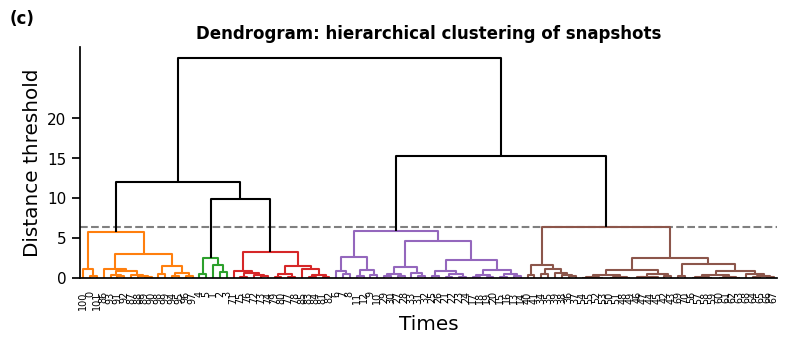

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

if clustering_method != "k_means":
    cluster_set.plot_dendrogram(ax=ax, leaf_font_size="xx-small")

    ax.set_ylabel("Distance threshold", fontsize="large")
    ax.set_xlabel("Times", fontsize="large")
    ax.set_yticks(range(0, 21, 5))
    ax.set_title("Dendrogram: hierarchical clustering of snapshots", weight="bold")

sb.despine()

# label subplots
ax.text(-0.1, 1.1, f"(c)", transform=ax.transAxes, size="medium", weight="bold")

plt.show()

### 2.2 Range of number of clusters: exploring timescales

In [23]:
cluster_sets = pk.ClusterSets.from_distance_matrix(
    distance_matrix, n_max_type, n_max_range, clustering_method
)

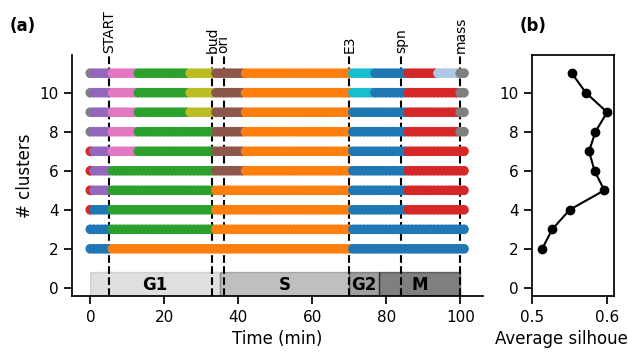

In [24]:
# Plot
gridspec_kw = {"width_ratios": [5, 1]}
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 3.5), gridspec_kw=gridspec_kw, sharey="all"
)

cluster_sets.plot(axs=(ax1, ax2), with_silhouettes=True)
pk.adjust_margin(ax=ax1, bottom=0.2 if phases else 0.05, top=0.05)
pk.plot_events(events, ax=ax1)
pk.plot_phases(phases, ax=ax1, y_pos=0.05, ymax=0.1)

# Format
ax1.set_xlabel("Time (min)")
ax1.set_axisbelow(True)
ax1.set_ylabel("# clusters")

if time_ticks:
    ax1.set_xticks(time_ticks)
sb.despine(ax=ax1)

ax2.set_xlabel("Average silhouette")
ax2.set_xlim((-0.1, 1.1))
ax2.set_xlim((0.5, 0.61))
ax2.yaxis.set_tick_params(labelleft=True)

plt.subplots_adjust(wspace=0.2, top=0.8)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.15,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

plt.show()